In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from skimage.feature import hog
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Dataset

In [16]:
class DataLoader:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = []
        self.image_labels = []

        if not os.path.exists(self.root_dir):
            raise FileNotFoundError("File not Found")
        else:
            for idx, dir in enumerate(os.listdir(self.root_dir)):
                img_folder = os.path.join(self.root_dir, dir)
                for img in os.listdir(img_folder):
                    img_path = os.path.join(img_folder, img)
                    img = cv2.imread(img_path)
                    if img is not None:
                        self.images.append(img)
                        self.image_labels.append(idx)
                    else:
                        print(f'{img} is none')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.image_labels[idx]

    def __iter__(self):
        for img, label in zip(self.images, self.image_labels):
            yield img, label

In [17]:
dataPath = os.path.join('..', 'data')
truth_label = {}

for idx, dir in enumerate(os.listdir(dataPath)):
    truth_label[idx] = dir

print(truth_label)

{0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'sadness', 6: 'surprise'}


In [18]:
img_dataset = DataLoader(dataPath)
len(img_dataset)

981

## Preprocessing

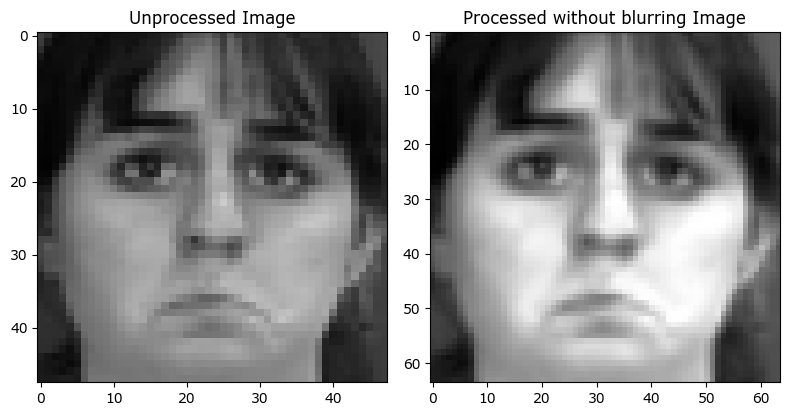

In [19]:
img, _ = img_dataset[710]

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resize_img = cv2.resize(gray_img, (64, 64))
equalize_img = cv2.equalizeHist(resize_img)
# final_img = cv2.medianBlur(equalize_img, 3)

plt.figure(figsize=(8,6))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Unprocessed Image")
# plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(equalize_img, 'gray')
plt.title("Processed without blurring Image")
# plt.axis('off')


plt.tight_layout()

In [25]:
def preprocess(img, resize=(64, 64)):
    """
    return processed image in Gray format
    """
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resize_img = cv2.resize(gray_img, resize)
    equalize_img = cv2.equalizeHist(resize_img)
    
    return equalize_img

# plt.imshow(preprocess(img), 'gray')

## Feature Extraction

2800

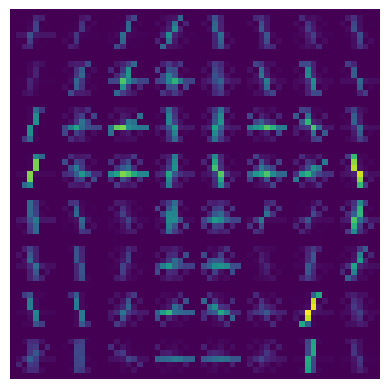

In [21]:
hog_features, hog_image = hog(
    equalize_img,
    orientations=7,               
    pixels_per_cell=(8, 8),      
    cells_per_block=(4, 4),       
    block_norm= 'L2-Hys',
    visualize=True,               
    channel_axis=None           
)

plt.imshow(hog_image)
plt.axis('off')
len(hog_features)

In [22]:
def extract_with_hog(img, orientation=7, pixels_per_cell=(8, 8), cells_per_block=(4,4)):
    """
    return hog features in vector
    """

    hog_features = hog(
        img,
        orientations=orientation,               
        pixels_per_cell=pixels_per_cell,      
        cells_per_block=cells_per_block,
        block_norm = 'L2-Hys',
        visualize=False,               
        channel_axis=None 
    )

    return hog_features

# arr = extract_with_hog(equalize_img)
# len(arr), type(arr)

## Training

In [31]:
# preprocess and extract the feature
features = np.array([extract_with_hog(preprocess(img)) for img, _ in img_dataset])
labels = np.array(img_dataset.image_labels)

# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
X_train.shape, X_test.shape

((784, 2800), (197, 2800))

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm = SVC(kernel='rbf', gamma='scale', C=1, probability=True)
scores = cross_val_score(svm, X_train, y_train, cv=skf)
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation accuracy scores: [0.94904459 0.96178344 0.95541401 0.94904459 0.94230769]
Mean accuracy: 0.9515188633023028


In [42]:
svm.fit(X_train, y_train)
train_output = svm.predict(X_train)
print(classification_report(y_train, train_output))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       108
           1       1.00      0.98      0.99        43
           2       1.00      1.00      1.00       142
           3       0.98      1.00      0.99        60
           4       1.00      1.00      1.00       165
           5       0.99      1.00      0.99        67
           6       1.00      1.00      1.00       199

    accuracy                           1.00       784
   macro avg       1.00      1.00      1.00       784
weighted avg       1.00      1.00      1.00       784



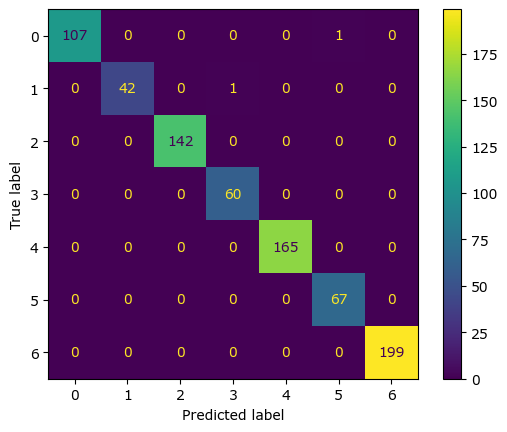

In [ ]:
cm = confusion_matrix(y_train, train_output, labels=svm.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_).plot()

mislabelling: anger(true label) - sadness, contempt(true label) - fear

## Inference

In [47]:
test_output = svm.predict(X_test)
print(classification_report(y_test, test_output))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        27
           1       1.00      0.82      0.90        11
           2       0.97      0.91      0.94        35
           3       0.88      1.00      0.94        15
           4       0.93      1.00      0.97        42
           5       0.89      0.94      0.91        17
           6       1.00      1.00      1.00        50

    accuracy                           0.95       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.96      0.95      0.95       197



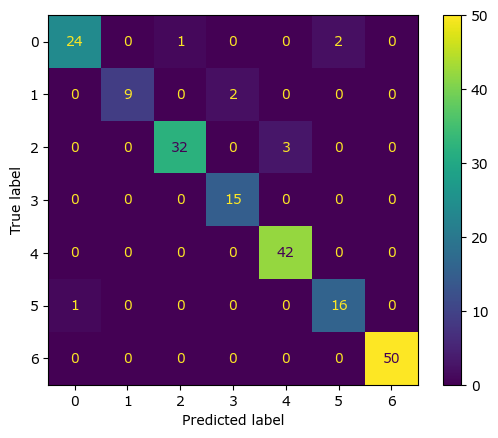

In [48]:
cm = confusion_matrix(y_test, test_output, labels=svm.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_).plot()